# Engineering Notebook

## By Rakesh Nori, Soham Bose

This is the engineering notebook for the second design project in CS 262. Our assignment was to build a model of a small, asynchronous distributed system that runs on a single machine but models multiple machines, each with their own logical clock, that run at different speeds.

## Initialization

To begin the process of initialization, 3 separate processes are created, with each serving as a virtual machine. The configuration parameters for each process include the local host address, server/consumer port, two producer ports, and the randomly generated clock rate. For each process, global variables according to the random code, message queue, logical clock, and locks for the queue, clock, and log are initialized. The final step of initialization steps is to create a log file for each of the separate ports where relevant information is stored.

## Producers and Consumers

After initialization is done for each process, a thread is created for the consumer, which acts as a server that binds to a port and listens to connections from producers from other machines. Each producer from the other machine that connects to the consumer port causes a new thread to be created. The consumer thread is responsible for receiving messages from producers and adding them to the message queue. Locks are placed on the message queue in order to avoid race conditions where the queue is accessed or changed out of turn. After the consumer thread is created, a delay is added in order to allow the listeners to have time to be ready and two producer threads are created. Each producer thread is associated with a number 1 or 2 which is associated with the randomly generated $code$ value, allowing us to differentiate which machine information must be sent to.  

The producer thread is responsible for sending messages to the consumer on the other virtual machines. Each producer thread is associated with a port that isn't being used by the consumer. Additionally, we decided to add a delay of $\frac{1}{rate}$ seconds after the first producer thread was started in order to guarantee that only $rate$ number of instructions could be performed per real world second on the virtual machine. We also added a delay of $\frac{2}{rate}$ seconds between each new code being generated. The delay is $\frac{2}{rate}$ since there are 2 threads, each of which need a delay of $\frac{1}{rate}$, and we don't want a new code to be created and accessed by a thread before all threads are finished processing the action corresponding to the initially generated code.  

## Clock Cycle Logic

For all local logical clock updates, we implemented a locking mechanism to prevent race conditions where the clock is accessed or changed out of turn. Similarly, we implemented a locking mechanism for the printed events as well to avoid any possible race conditions. A locking mechanism was also implemented whenever anything was read from the message queue.

Within the producer thread exists the call to the function $update$, which defines the clock cycle logic that updates the local logical clock of each virtual machine. To start, we looked at defining the case where there were messages in the queue of the machine that needed to be read. For this case, we have received a message containing the local logical clock time of another machine, which needs to be read and then compared to the current machine's local logical clock time. In accordance with the principles of a Lamport clock, the maximum time is chosen as the current machine's new local logical clock time, with 1 added since a message was read and an operation was done.

We then began by defining the simple cases of the generated $code$ being 1 or 2, in which case we took advantage of the number associated with each producer thread to match with the generated $code$ value and send the local logical clock time to the correct virtual machine, update the local logical clock, and print a log that a message was sent. We then took care of the other simpler case where $code \geq 4$, in which case an internal event log was printed and the local logical clock was updated. 

Once the simpler cases were implemented, we moved on to the case where $code = 3$. To start, an array $finished$ was defined in order to track which of the machines had messages sent to it. Initially, when the first thread enters the loop, the message containing the logical clock time is immediately sent to the first machine, after which the number associated with the virtual machine that the message was sent to was added to the $finished$ array to signify that the operation had been finished. No clock update was made since the full operation associated with the code being 3 hadn't been finished. Next, to define the behavior when the second thread enters the loop, the logical clock time was also immediately sent to the associated machine but the following logic was changed in order to allow for reusability. We decided to check if $finished$ was already populated in order to know that the first thread had already gone through it's intended behavior and then decide to reset the $finished$ array, update the clock since the entire operation had now been finished, and log that a message had been sent to both machines. 

We added an edge case where the code may change before both threads are able to run by checking if our $finished$ array was not empty and the code was not 3, which meant that the behavior of the 2nd thread hadn't occurred since the $finished$ array wasn't cleared. In this case where the $code$ had been wrongly updated before the full behavior of both threads had occurred, we immediately force the behavior of the 2nd thread to occur where the logical clock time is sent to the associated machine, $finished$ is cleared, the clock is updated, and a message sent event is logged. 

## Experiments

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
RATE_CONST = {1: [5, 4, 2], 2: [6, 4, 5], 3: [5, 4, 3], 4: [6, 3, 6], 5: [5, 5, 1]}

In [5]:
def parse_logs(log_path):
    logs = pd.read_fwf(log_path, header = None)
    unparsed_logs = logs[0].values
    parsed_logs = [log for log in unparsed_logs if 'time' in log]
    return parsed_logs

In [6]:
log_dict = {}
ports = [2056, 3056, 4056]
for i in range(1,6):
    logs = []
    for port in ports:
        path = "logs/log_" + str(port) + "_" + str(i) + ".txt"
        logs.append(parse_logs(path))
    log_dict[i] = logs
    
    

In [7]:
def get_logical_clock(logs):
    logical_clock = []
    for event in logs:
        logical_clock.append(int(event[event.rfind(',') + 2:]))
    return logical_clock

In [8]:
def get_clock_jumps(logical_clock):
    clock_jumps = []
    for i in range(len(logical_clock) - 1):
        clock_jumps.append(logical_clock[i + 1] - logical_clock[i])
    return clock_jumps

In [9]:
clock_dict = {}
for key in log_dict.keys():
    clock_dict[key] = [get_logical_clock(log_dict[key][i]) for i in range(len(log_dict[key]))]

In [10]:
clock_jumps_dict = {}
for key in clock_dict.keys():
    clock_jumps_dict[key] = [get_clock_jumps(clock_dict[key][i]) for i in range(len(clock_dict[key]))]

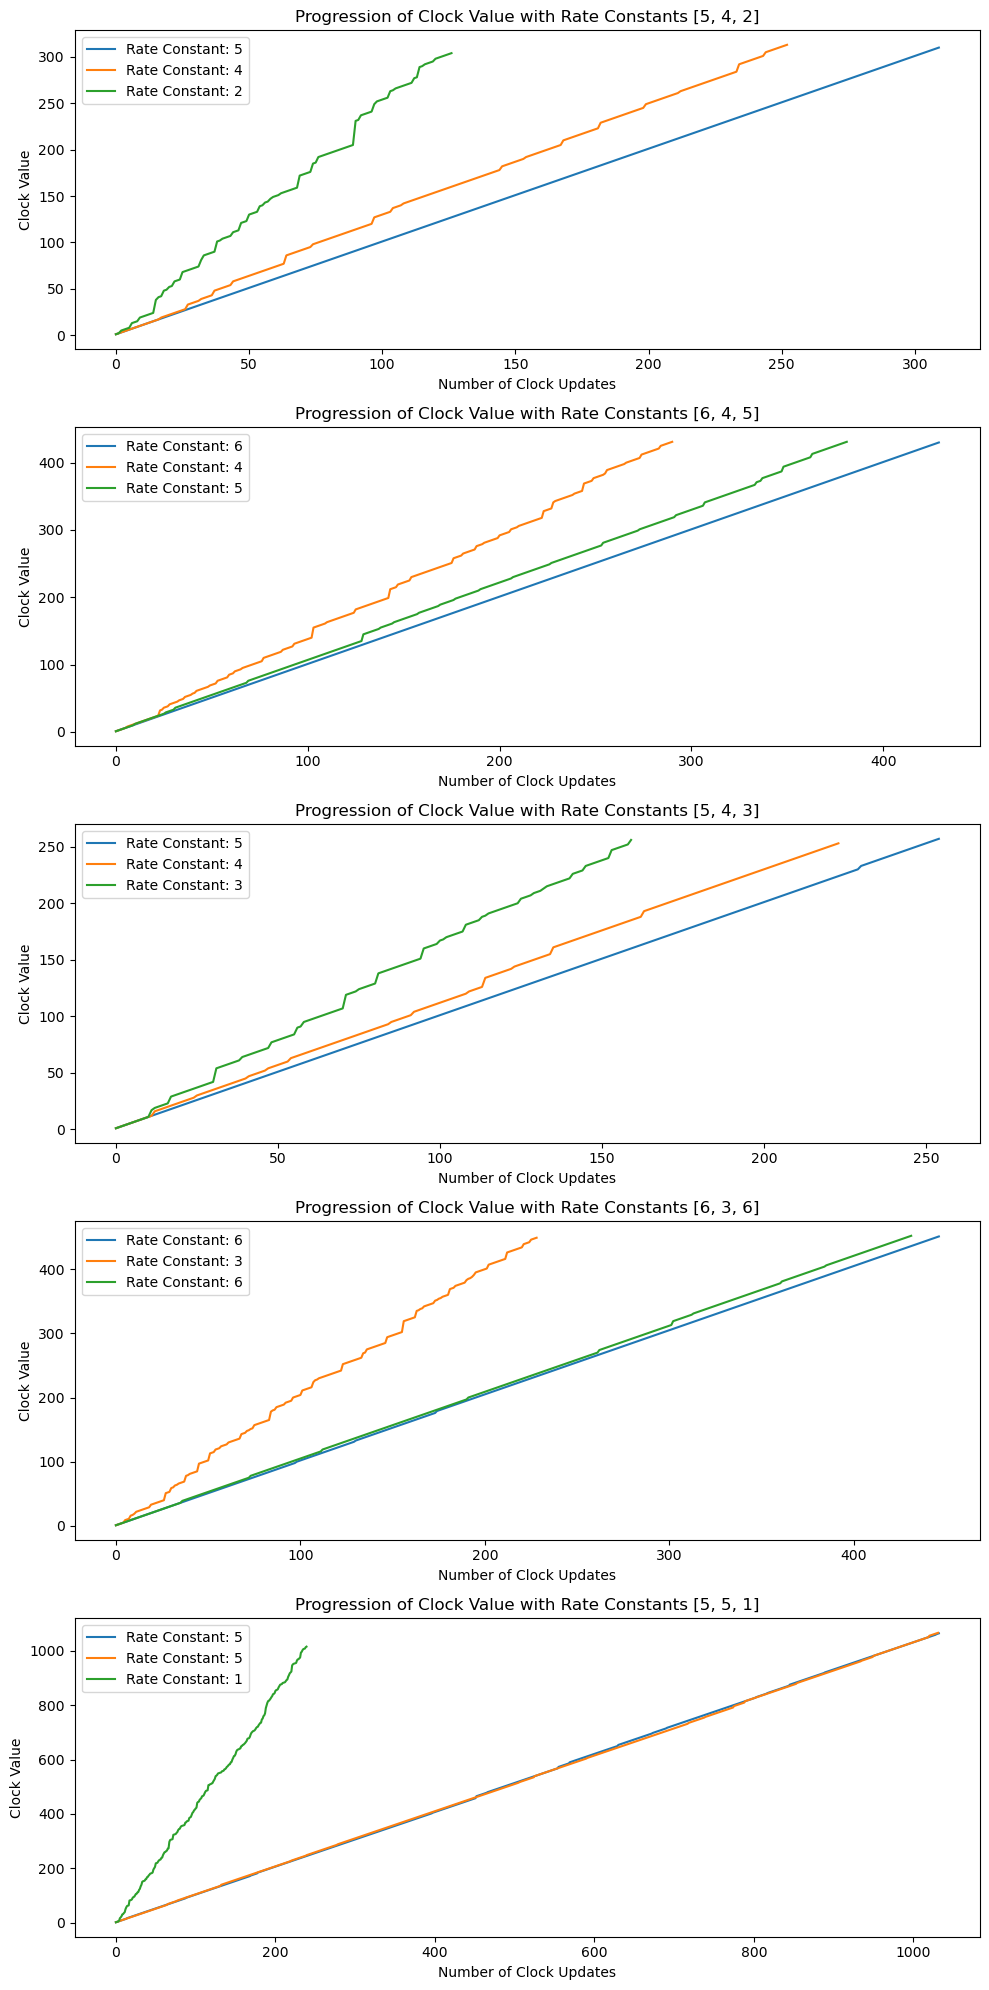

In [11]:
fig, axs  = plt.subplots(5, 1, figsize = (10,20))
for key in clock_dict.keys():
    for i in range(len(clock_dict[key])):
        axs[key - 1].plot(clock_dict[key][i], label = "Rate Constant: " + str(RATE_CONST[key][i]))
        axs[key - 1].set_title("Progression of Clock Value with Rate Constants " + str(RATE_CONST[key]))
        axs[key - 1].set_xlabel("Number of Clock Updates")
        axs[key - 1].set_ylabel("Clock Value")
        axs[key - 1].legend()
fig.tight_layout()

## Discussion of Clock Value Progression
The set of graphs above show the 5 different runs of the set of virtual machines with the value of the clock plotted against the number of updates that occurred to the clock. The number of updates that occurred to the clock is determined by the length of the logs for the port. We expect the number of updates to the clock to be highest and most consistent for the machine with the highest rate constants. In each of the graphs, we can see that the line according to the highest rate constant is the most smooth while the other lines have a less smooth progression to the final clock value. The slope of the lines are nearly proportional to the ratio between the rate values since the rate value determines the number of operations per real world second and therefore the speed of progression in the clock value and number of clock updates. When the rate constants of each machine are similar, we see that the lines progress similarly towards the final clock value whereas highly different rate constants lead to very different slopes and smoothness. This can be seen in the last graph where two machines have a rate constant of 5 and one machine has a rate constant of 1. The machine with rate constant 1 needed around 200 updates to get to the final clock value of 1000 whereas the machines with rate constant 5 needed around 1000 updates to get to the final clock value of 1000. This is expected behavior as the clock value of the machine with rate constant 1 will update to the maximum of the two machines whenever a message is received from another machine, causing it to need less updates since the clock values of the machines with rate constant 5 will progress in their clock value much faster since around 5 times as many operations are occurring. 

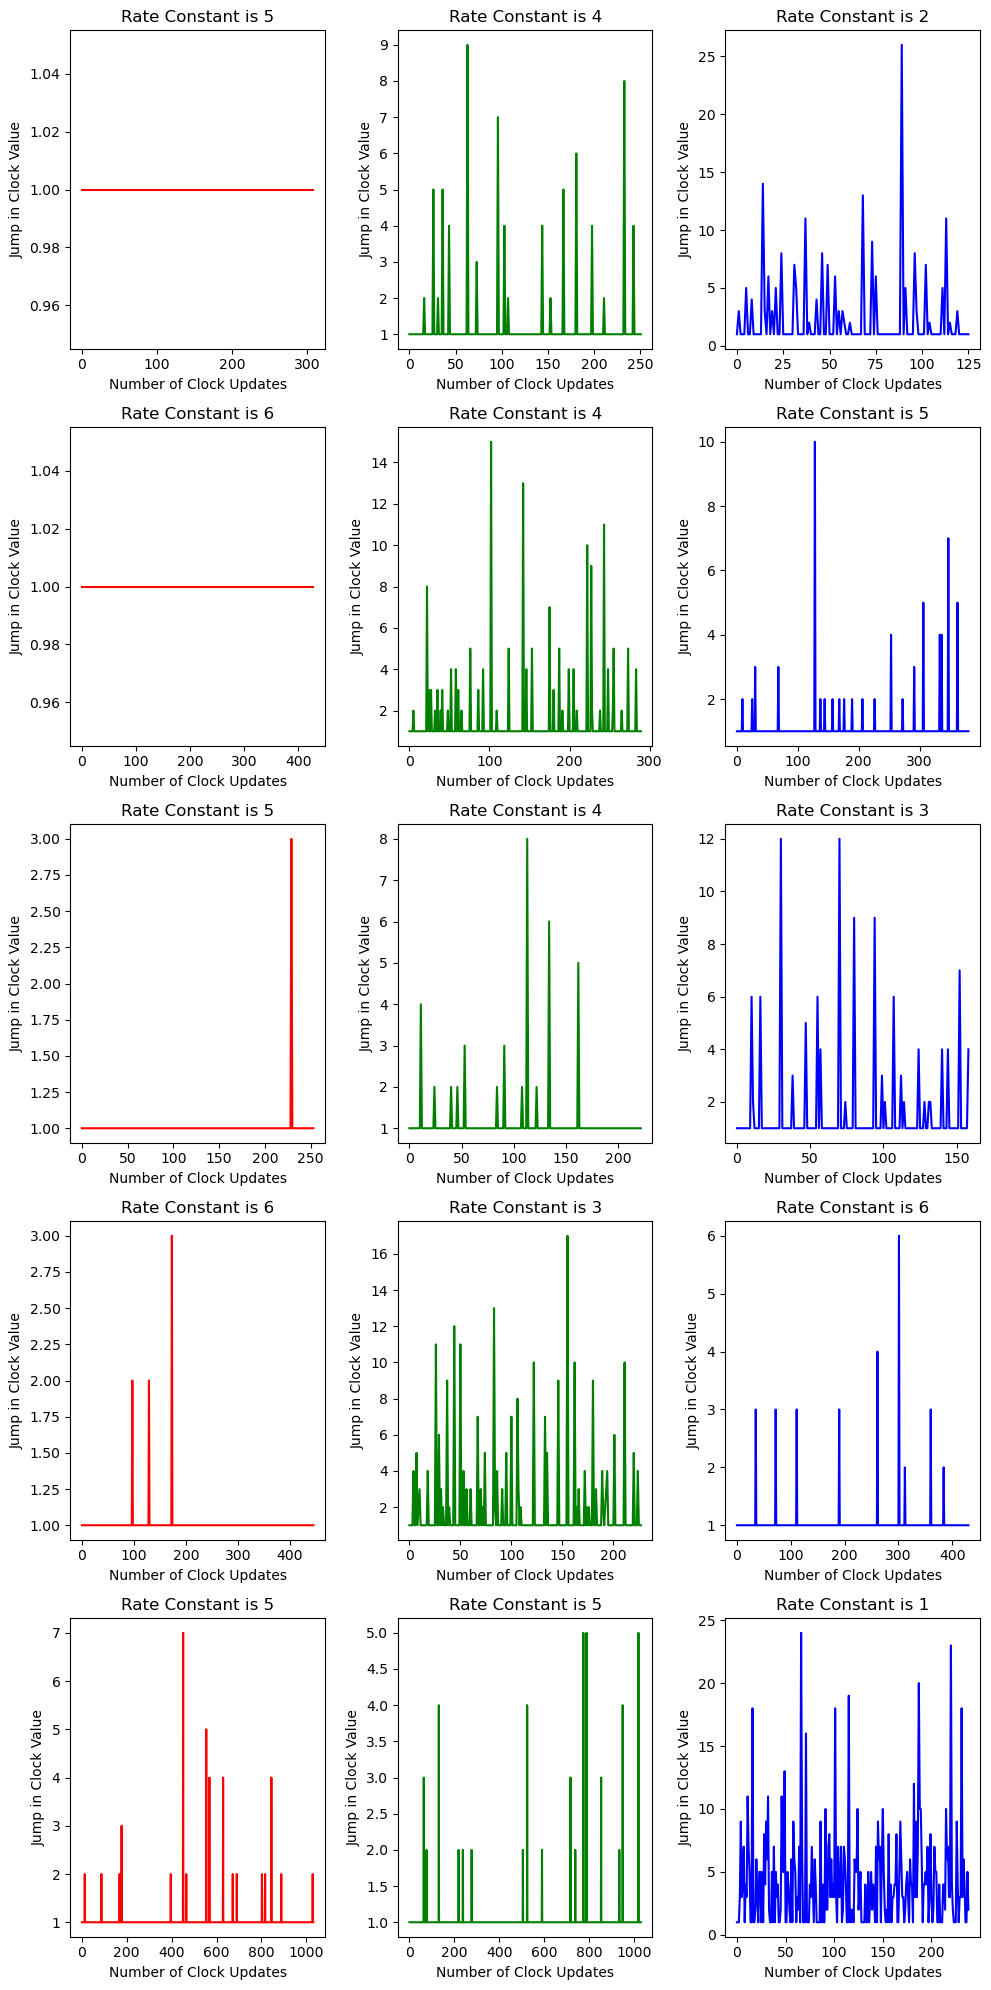

In [12]:
fig, axs = plt.subplots(5, 3, figsize = (10,20))
colors = ['r', 'g', 'b']
for key in clock_jumps_dict.keys():
    for i in range(len(clock_jumps_dict[key])):
        axs[key - 1][i].plot(clock_jumps_dict[key][i], label = str(key), color = colors[i])
        axs[key - 1][i].set_title("Rate Constant is " + str(RATE_CONST[key][i]))
        axs[key - 1][i].set_xlabel("Number of Clock Updates")
        axs[key - 1][i].set_ylabel("Jump in Clock Value")
fig.tight_layout()

## Discussion of Clock Value Jumps
The set of graphs above show the 5 different runs of the set of virtual machines with the jump in the clock value plotted against the number of updates that occurred to the clock. The expected behavior is that a machine with a lower rate constant will have higher jumps in the clock value as other machines with higher rate constants will have their clock value progress at a much faster rate. Thus, when a message is sent to the machine with a lower rate constant, it will force the lower clock value to update to the maximum of the two clock values, causing a jump in the lower clock value. Higher rate constants will have higher clock values in less time since more operations are done per real world second, causing the clock value to increase faster. Thus, in each of the graphs above, we see that there are very few clock jumps for the machines with the highest rate constants and clock jumps of higher magnitude as the rate constants get lower. For example, in the first row of graphs, there are no jumps in clock value for the machine with rate constant 5, a maximum clock jump of 9 when the rate constant is 4, and a maximum clock jump of around 25 when the rate constant is 2. This aligns with our expected behavior that larger clock jumps will occur when there are larger differences between the rate constants of different machines.   

In [13]:
log_dict_lowvar = {}
ports = [2056, 3056, 4056]
for i in range(1, 2):
    logs = []
    for port in ports:
        path = "logs_less_var/log_" + str(port) + "_lowvar.txt"
        logs.append(parse_logs(path))
    log_dict_lowvar[i] = logs

In [14]:
clock_dict_lowvar = {}
for key in log_dict_lowvar.keys():
    clock_dict_lowvar[key] = [get_logical_clock(log_dict_lowvar[key][i]) for i in range(len(log_dict_lowvar[key]))]

In [15]:
clock_jumps_dict_lowvar = {}
for key in clock_dict_lowvar.keys():
    clock_jumps_dict_lowvar[key] = [get_clock_jumps(clock_dict_lowvar[key][i]) for i in range(len(clock_dict_lowvar[key]))]

In [16]:
RATE_CONST_LOWVAR = {1: [1,3,3]}

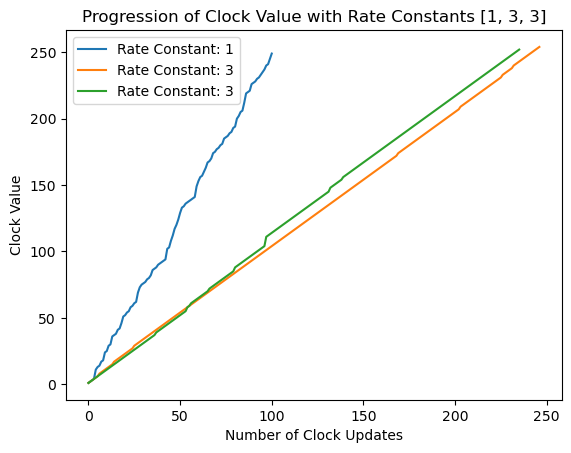

In [19]:
for key in clock_dict_lowvar.keys():
    for i in range(len(clock_dict_lowvar[key])):
        plt.plot(clock_dict_lowvar[key][i], label = "Rate Constant: " + str(RATE_CONST_LOWVAR[key][i]))
        plt.title("Progression of Clock Value with Rate Constants " + str(RATE_CONST_LOWVAR[key]))
        plt.xlabel("Number of Clock Updates")
        plt.ylabel("Clock Value")
        plt.legend()

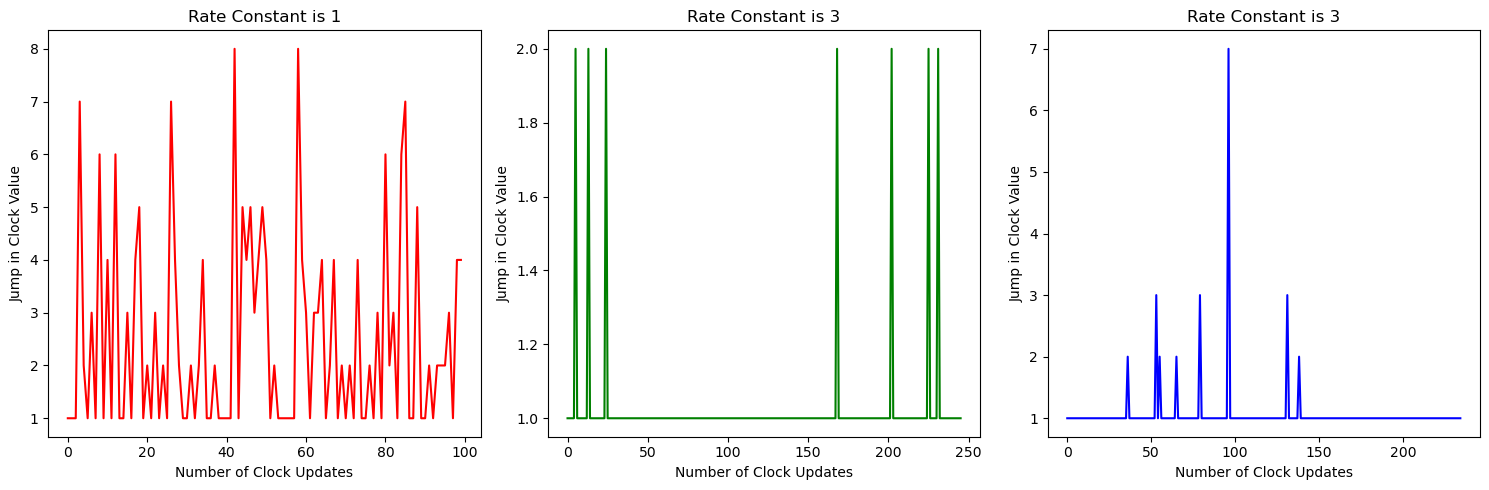

In [31]:
fig, axs = plt.subplots(1, 3, figsize = (15,5))
colors = ['r', 'g', 'b']
for key in clock_jumps_dict_lowvar.keys():
    for i in range(len(clock_jumps_dict_lowvar[key])):
        axs[i].plot(clock_jumps_dict_lowvar[key][i], label = str(key), color = colors[i])
        axs[i].set_title("Rate Constant is " + str(RATE_CONST_LOWVAR[key][i]))
        axs[i].set_xlabel("Number of Clock Updates")
        axs[i].set_ylabel("Jump in Clock Value")
fig.tight_layout()

## Discussion of Low Variance Clock Value Progression and Jumps
For the set of graphs above, the rate variability was decreased from 6 potential values to 3 potential values while the probability of the event being internal was also decreased from 70% to 50%. The probability of an event being internal going down led to more messages being sent and received, which led to more potential jumps in the clock value. Thus, we see that there are jumps of higher magnitude even when the rate constant is high. For example, there is a jump of relatively high magnitude even when the machine is tied for the highest rate constant. In a case with less rate variability, it is more likely that two machines will be tied for the highest rate constant, which can lead to clock jumps compared to the case when there is higher rate variability as it is less likely that two machines will be tied for the highest rate constant.